## Phase: Modeling Building

Now that I have a basic sense of the visualization, I want to start modeling the data.

However, because I didn't save my work from yesterday, I'll go back to the noteook and save the result to disk, so I can use it here and maybe somewhere else.

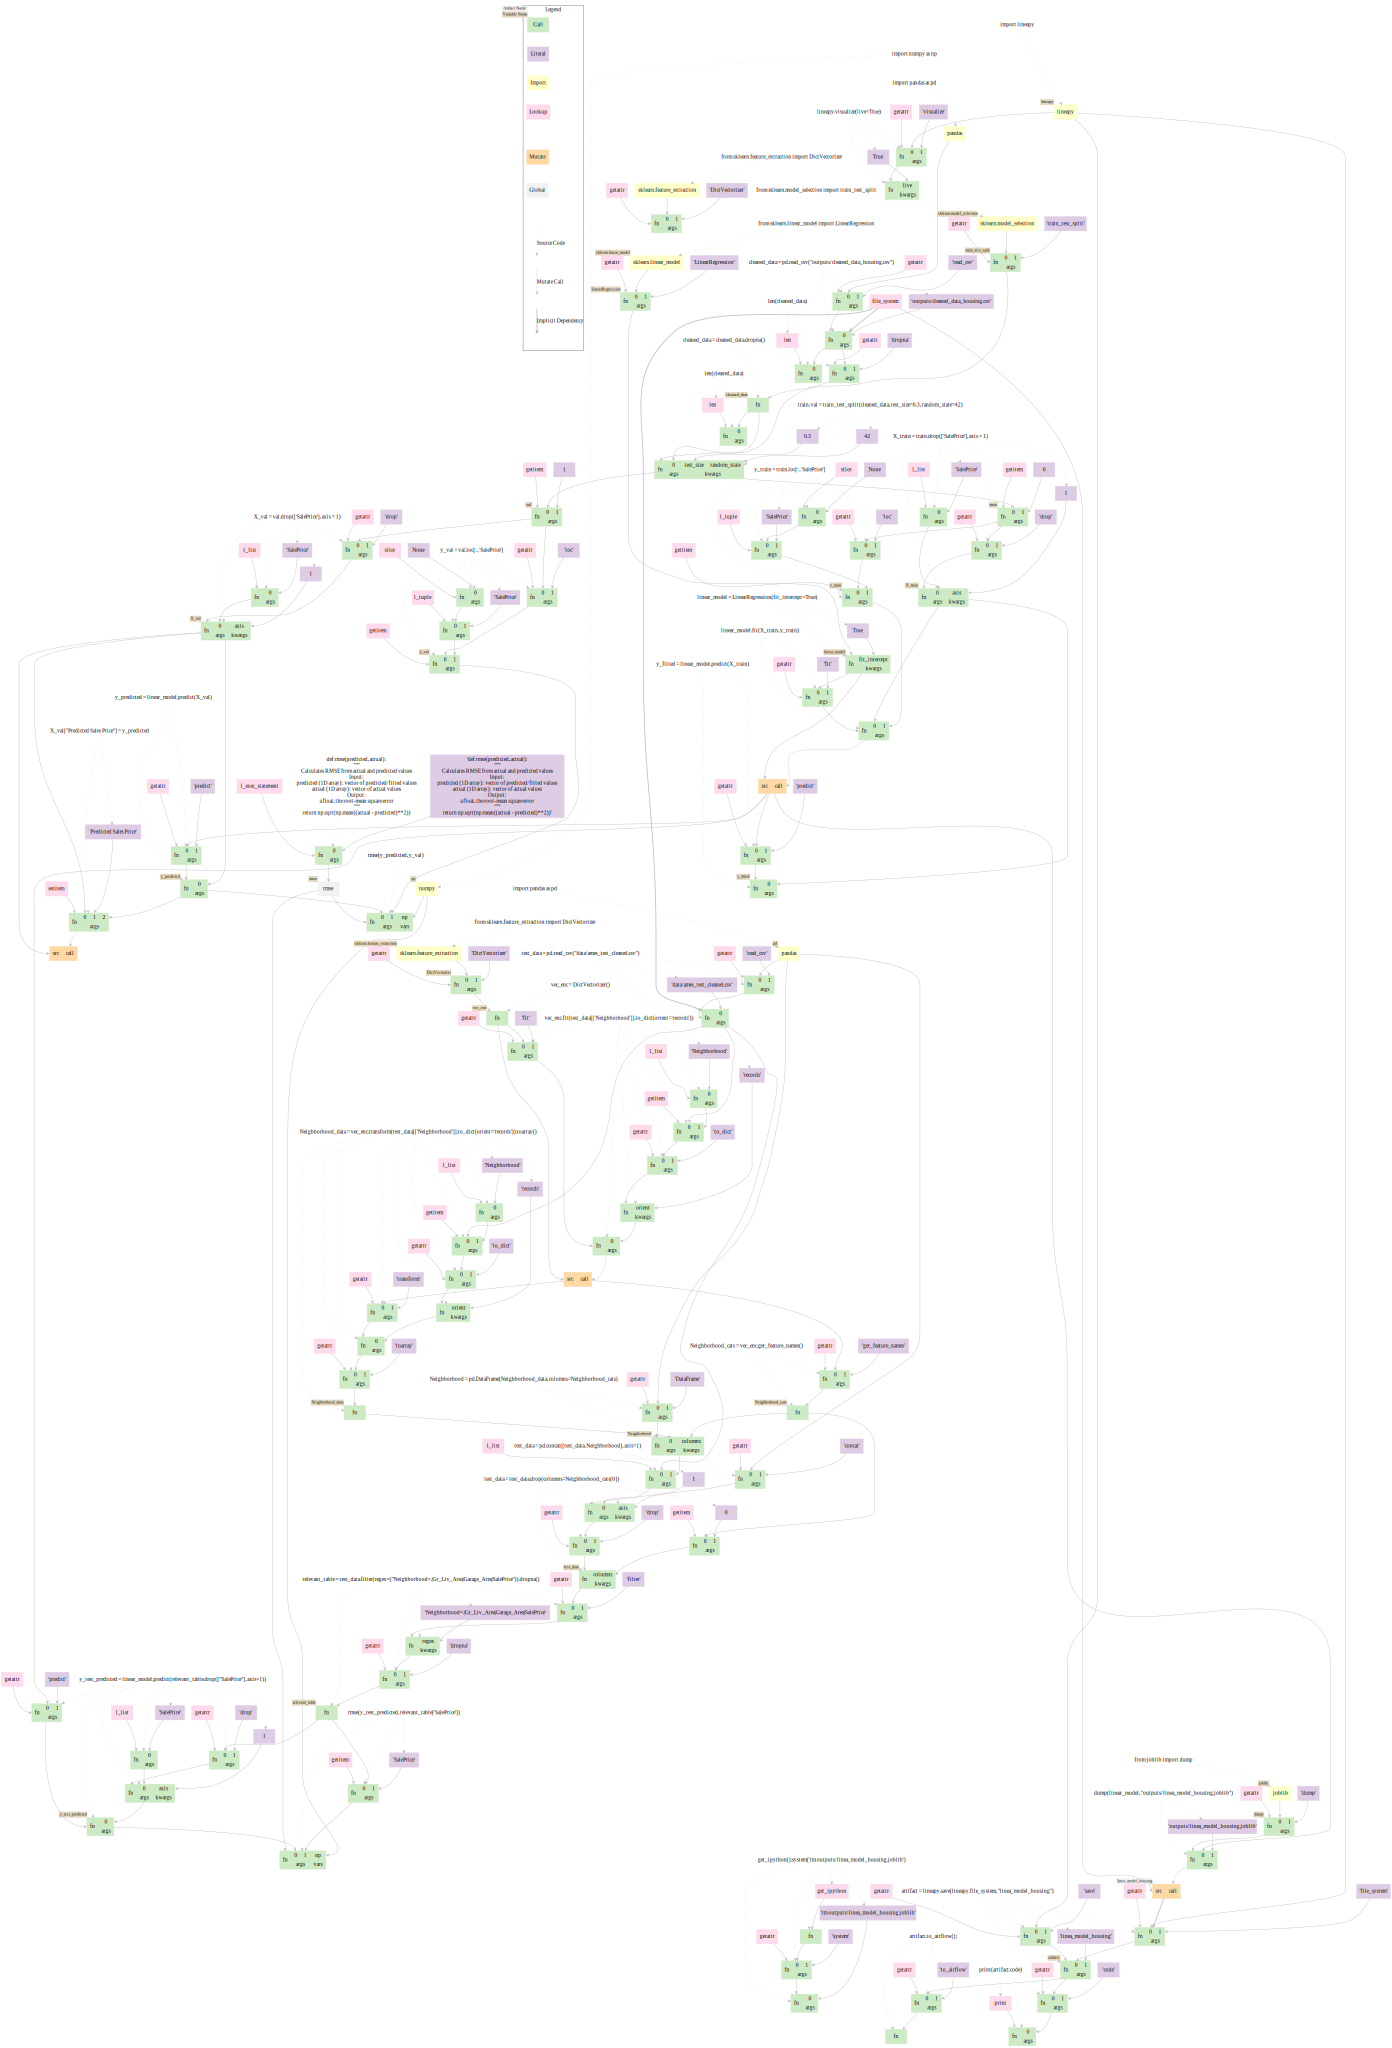

In [1]:
import lineapy
import numpy as np
import pandas as pd
lineapy.visualize(live=True)

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [3]:
cleaned_data = pd.read_csv("outputs/cleaned_data_housing.csv")

In [4]:
len(cleaned_data)

1998

In [5]:
cleaned_data = cleaned_data.dropna()

In [6]:
len(cleaned_data)

1960

In [7]:
train, val = train_test_split(cleaned_data, test_size=0.3, random_state=42)
X_train = train.drop(['SalePrice'], axis = 1)
y_train = train.loc[:, 'SalePrice']
X_val = val.drop(['SalePrice'], axis = 1)
y_val = val.loc[:, 'SalePrice']

In [8]:
X_train

,Gr_Liv_Area,Garage_Area,Neighborhood=Blueste,Neighborhood=BrDale,Neighborhood=BrkSide,Neighborhood=ClearCr,Neighborhood=CollgCr,Neighborhood=Crawfor,Neighborhood=Edwards,Neighborhood=Gilbert,Neighborhood=Greens,Neighborhood=GrnHill,Neighborhood=IDOTRR,Neighborhood=MeadowV,Neighborhood=Mitchel,Neighborhood=NAmes,Neighborhood=NPkVill,Neighborhood=NWAmes,Neighborhood=NoRidge,Neighborhood=NridgHt,Neighborhood=OldTown,Neighborhood=SWISU,Neighborhood=Sawyer,Neighborhood=SawyerW,Neighborhood=Somerst,Neighborhood=StoneBr,Neighborhood=Timber,Neighborhood=Veenker
1026,2192.0,240.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1275,1187.0,440.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
777,2786.0,636.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
870,407.0,297.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
615,1981.0,576.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,1816.0,730.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1306,924.0,420.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
866,1080.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1472,1152.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
y_train

1026    171700.0
1275    133800.0
777     364400.0
870      54400.0
615     125600.0
          ...   
1139    362800.0
1306    105500.0
866      87000.0
1472     68200.0
1135    119600.0
Name: SalePrice, Length: 1372, dtype: float64

In [10]:
linear_model = LinearRegression(fit_intercept=True)

In [11]:
linear_model.fit(X_train, y_train)
y_fitted = linear_model.predict(X_train)
y_predicted = linear_model.predict(X_val)

In [12]:
X_val["Predicted Sales Price"] = y_predicted

## Use the prediction on split test data

Now that we have built the data, we want to take a look at how accurate we are

In [13]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

In [14]:
# NBVAL_IGNORE_OUTPUT
rmse(y_predicted, y_val)

44444.3760803208

## Use the prediction on new test data

In [15]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer

test_data = pd.read_csv("data/ames_test_cleaned.csv")

In [16]:
# NBVAL_IGNORE_OUTPUT
vec_enc = DictVectorizer()
vec_enc.fit(test_data[['Neighborhood']].to_dict(orient='records'))
Neighborhood_data = vec_enc.transform(test_data[['Neighborhood']].to_dict(orient='records')).toarray()
Neighborhood_cats = vec_enc.get_feature_names()
Neighborhood = pd.DataFrame(Neighborhood_data, columns=Neighborhood_cats)
test_data = pd.concat([test_data, Neighborhood], axis=1)
test_data = test_data.drop(columns=Neighborhood_cats[0])

/usr/local/Caskroom/miniconda/base/envs/lineapy/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
# new_res = lineapy.run(after_load, {input_data: pd.read_csv("../ames_other_cleaned.csv")})

In [18]:
relevant_table = test_data.filter(regex=("Neighborhood=.|Gr_Liv_Area|Garage_Area|SalePrice")).dropna()

In [19]:
relevant_table

,Gr_Liv_Area,Garage_Area,SalePrice,Neighborhood=Blueste,Neighborhood=BrDale,Neighborhood=BrkSide,Neighborhood=ClearCr,Neighborhood=CollgCr,Neighborhood=Crawfor,Neighborhood=Edwards,Neighborhood=Gilbert,Neighborhood=Greens,Neighborhood=IDOTRR,Neighborhood=Landmrk,Neighborhood=MeadowV,Neighborhood=Mitchel,Neighborhood=NAmes,Neighborhood=NPkVill,Neighborhood=NWAmes,Neighborhood=NoRidge,Neighborhood=NridgHt,Neighborhood=OldTown,Neighborhood=SWISU,Neighborhood=Sawyer,Neighborhood=SawyerW,Neighborhood=Somerst,Neighborhood=StoneBr,Neighborhood=Timber,Neighborhood=Veenker
0,1338,582.0,213500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1804,442.0,189000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1655,440.0,175900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1502,528.0,212000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,3279,841.0,538000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,1360,336.0,140000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
926,1092,286.0,71000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
927,1728,574.0,150900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
928,1126,484.0,160000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# NBVAL_IGNORE_OUTPUT
y_test_predicted = linear_model.predict(relevant_table.drop(["SalePrice"], axis=1))

/usr/local/Caskroom/miniconda/base/envs/lineapy/lib/python3.9/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Neighborhood=Landmrk
Feature names seen at fit time, yet now missing:
- Neighborhood=GrnHill

  warnings.warn(message, FutureWarning)


In [21]:
rmse(y_test_predicted, relevant_table['SalePrice'])

43942.866825768746

I've verified that the test results are still within the expected range.

In [22]:
from joblib import dump
dump(linear_model, "outputs/linea_model_housing.joblib")

['outputs/linea_model_housing.joblib']

## Task 2: App API

I want to deploy this model so the business folks come in and take my "suggested" values.

I would either have to learn flask and AWs to put a mini web app up, or make the business folks use a notebook (which involves setting up Python).

In [23]:
!rm outputs/linea_model_housing.joblib

In [24]:
artifact = lineapy.save(lineapy.file_system, "linea_model_housing")

In [25]:
artifact.to_airflow();

Added Airflow DAG named 'linea_model_housing'. Start a run from the Airflow UI or CLI.


In [26]:
print(artifact.code)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
cleaned_data = pd.read_csv("outputs/cleaned_data_housing.csv")
cleaned_data = cleaned_data.dropna()
train, val = train_test_split(cleaned_data, test_size=0.3, random_state=42)
X_train = train.drop(['SalePrice'], axis = 1)
y_train = train.loc[:, 'SalePrice']
linear_model = LinearRegression(fit_intercept=True)
linear_model.fit(X_train, y_train)
from joblib import dump
dump(linear_model, "outputs/linea_model_housing.joblib")

